In [1]:
from matplotlib.dates import date2num, num2date
from matplotlib.colors import ListedColormap
from matplotlib import dates as mdates
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
from matplotlib import ticker
from scipy.stats import truncnorm
from tqdm import tqdm


import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import math
import sys
import os

sys.path.insert(0, '..')

from functions.adjust_cases_functions import prepare_cases, smooth_1d

In [2]:
# read population
pop        = 40000000.0


# read cases by age without filtering
# previously group them in the ages of interest.
cases_df = pd.read_csv(os.path.join('../data/DatosW.csv'), delimiter=";", parse_dates=["Dates"], dayfirst=True).set_index('Dates')
cases_df['I_NV+PD'] = cases_df['InfectadosNoVacunados'].values+ cases_df['InfectadosPrimeraDosis'].values
cases_df['H_NV+PD'] = cases_df['HospitalizadosNoVacunados'].values + cases_df['HospitalizadosPrimeraDosis'].values
cases_df['M_NV+PD'] = cases_df['MuertesNoVacunados'].values + cases_df['MuertesPrimeraDosis'].values

cases_df = prepare_cases(cases_df, col='InfectadosNoVacunados')
cases_df = prepare_cases(cases_df, col='InfectadosPrimeraDosis')
cases_df = prepare_cases(cases_df, col='InfectadosEsquemaCompleto')
cases_df = prepare_cases(cases_df, col='InfectadosDosisRefuerzo')
cases_df = prepare_cases(cases_df, col='InfectadosTotal')
cases_df = prepare_cases(cases_df, col='HospitalizadosNoVacunados')
cases_df = prepare_cases(cases_df, col='HospitalizadosPrimeraDosis')
cases_df = prepare_cases(cases_df, col='HospitalizadosEsquemaCompleto')
cases_df = prepare_cases(cases_df, col='HospitalizadosDosisRefuerzo')
cases_df = prepare_cases(cases_df, col='HospitalizadosTotal')
cases_df = prepare_cases(cases_df, col='MuertesNoVacunados')
cases_df = prepare_cases(cases_df, col='MuertesPrimeraDosis')
cases_df = prepare_cases(cases_df, col='MuertesEsquemaCompleto')
cases_df = prepare_cases(cases_df, col='MuertesDosisRefuerzo')
cases_df = prepare_cases(cases_df, col='MuertesTotal')
cases_df = prepare_cases(cases_df, col='I_NV+PD')
cases_df = prepare_cases(cases_df, col='H_NV+PD')
cases_df = prepare_cases(cases_df, col='M_NV+PD')
cases_df

,InfectadosNoVacunados,InfectadosPrimeraDosis,InfectadosEsquemaCompleto,InfectadosDosisRefuerzo,InfectadosTotal,HospitalizadosNoVacunados,HospitalizadosPrimeraDosis,HospitalizadosEsquemaCompleto,HospitalizadosDosisRefuerzo,HospitalizadosTotal,...,smoothed_HospitalizadosDosisRefuerzo,smoothed_HospitalizadosTotal,smoothed_MuertesNoVacunados,smoothed_MuertesPrimeraDosis,smoothed_MuertesEsquemaCompleto,smoothed_MuertesDosisRefuerzo,smoothed_MuertesTotal,smoothed_I_NV+PD,smoothed_H_NV+PD,smoothed_M_NV+PD
Dates,,,,,,,,,,,,,,,,,,,,,
2020-03-06,0,0,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2020-03-07,1,0,0,0,1,1,0,0,0,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2020-03-08,1,0,0,0,1,1,0,0,0,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2020-03-09,1,0,0,0,1,1,0,0,0,1,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0
2020-03-10,3,0,0,0,3,2,0,0,0,2,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-03,9937,3,7,0,9947,0,0,1,0,1,...,0.0,11.0,317.0,21.0,89.0,1.0,428.0,10291.0,6.0,338.0
2021-11-04,9684,0,0,0,9684,0,0,0,0,0,...,0.0,4.0,328.0,18.0,76.0,1.0,422.0,9974.0,3.0,345.0
2021-11-05,9740,0,0,0,9740,0,0,0,0,0,...,0.0,1.0,334.0,16.0,68.0,1.0,420.0,9762.0,1.0,351.0


In [3]:
from scipy.interpolate import UnivariateSpline
IFR_Verity = [ .00161, .00695, .0309, .0844, .161, .595, 1.93, 4.28, 7.80 ]
ifr_log    = np.log(IFR_Verity)

IFR = np.zeros((80))

ages_fit   = [9, 19, 29, 39, 49, 59, 69, 79, 89]
ifr_fitted = UnivariateSpline(ages_fit, ifr_log)

x = np.arange(0, 90, 1)
fitted_ifr = ifr_fitted(x)

ages_models = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
# Create IFR every 5 years
ifr = np.exp([fitted_ifr[0:6].mean(),fitted_ifr[6:11].mean(),fitted_ifr[11:16].mean(),fitted_ifr[16:21].mean(),
       fitted_ifr[21:26].mean(),fitted_ifr[27:31].mean(),fitted_ifr[31:36].mean(),fitted_ifr[37:41].mean(),
       fitted_ifr[41:46].mean(),fitted_ifr[47:51].mean(),fitted_ifr[51:56].mean(),fitted_ifr[56:61].mean(),
       fitted_ifr[61:66].mean(),fitted_ifr[67:71].mean(),fitted_ifr[71:76].mean(),fitted_ifr[76:].mean()])/100 #%

ifr_m = np.mean(ifr)*3.533
# ifr_m = 0.01
iVfr  = 3.267*ifr_m#0.0181
print(ifr_m)
print(iVfr)

0.024749977542727945
0.0808581766320922


In [4]:
from models_pompAgg import modelV, init_modelV

param_prior_dict  = {}
param_prior_dict["beta"]  = [1, 1.1] #[1, 1.3]#       # Contact rate range
param_prior_dict["alpha"] = [0.3, 0.5]#[0.2, 0.3]#         # Report rate range [1% - 100%]
param_prior_dict["Vr"] = [1, 164746]#[0.2, 0.3]#         # Report rate range [1% - 100%]
param_prior_dictV ={"Vr":[1131, 1331]}

date_init  = pd.to_datetime("2021-02-15")
date_end   = pd.to_datetime("2021-10-27")


lambda_inf    = 1.1
num_params    = 3
num_iters_mif = 360
alpha_mif     = 0.9 # Variance shrinking factor
num_ensembles = 200
N             = pop
Vr            = np.array([2000]*num_ensembles) #82373
num_state_vars   = 16
num_observations = 4
num_iters_save   = 4
num_save_iters   = int(num_iters_mif/num_iters_save)

bog_cases_df = cases_df.reset_index()
obs_df = bog_cases_df
obs_df = obs_df.set_index("Dates")
obs_df  = obs_df.loc[date_init:date_end]
priors = np.load('../results/samples_agg_Final_450.npz')
param_prior = priors['param_posterior']
x_prior = priors['x_posterior']


oev_df                     = pd.DataFrame(columns=["Dates", "OEV_confirmed", "OEV_deaths"])
oev_df["Dates"]            = obs_df.index.values
oev_df                     = oev_df.set_index("Dates")
oev_df["OEV_confirmed"]    = 1 + (0.2*obs_df["smoothed_I_NV+PD"].values)**2 #np.maximum(1e-4, obs_df["smoothed_InfectadosNoVacunados"].values**2/100 )
oev_df["OEV_deaths"]       = 1 + (0.2*obs_df["smoothed_M_NV+PD"].values)**2 #np.maximum(25, obs_df["smoothed_MuertesNoVacunados"].values**2/100 )
oev_df["OEV_confirmedV"]    = 1 + (0.2*obs_df["smoothed_InfectadosEsquemaCompleto"].values)**2 #np.maximum(1e-4, obs_df["smoothed_InfectadosNoVacunados"].values**2/100 )
oev_df["OEV_deathsV"]       = 1 + (0.2*obs_df["smoothed_MuertesEsquemaCompleto"].values)**2 #np.maximum(25, obs_df["smoothed_MuertesNoVacunados"].values**2/100 )
dates_assimilation = obs_df.index.get_level_values(0).values
dates = dates_assimilation
num_steps = len(dates)

######## INFERENCE  SETTINGS ########
# Range of parameters
param_range = np.array([v for k, v in param_prior_dict.items()])
std_param   = param_range[:,1]-param_range[:,0]
SIG         = std_param ** 2 / 4; #  initial covariance of parameters

num_steps     = len(obs_df) #387

obs_post_all = np.zeros((num_observations, num_ensembles, num_steps, num_iters_save))

para_post_all = np.zeros((num_params, num_ensembles, num_steps, num_iters_mif))
x_post_all    = np.zeros((num_state_vars, num_ensembles, num_steps, num_iters_save))
theta         = np.zeros((num_params, num_iters_mif+1))
################################################

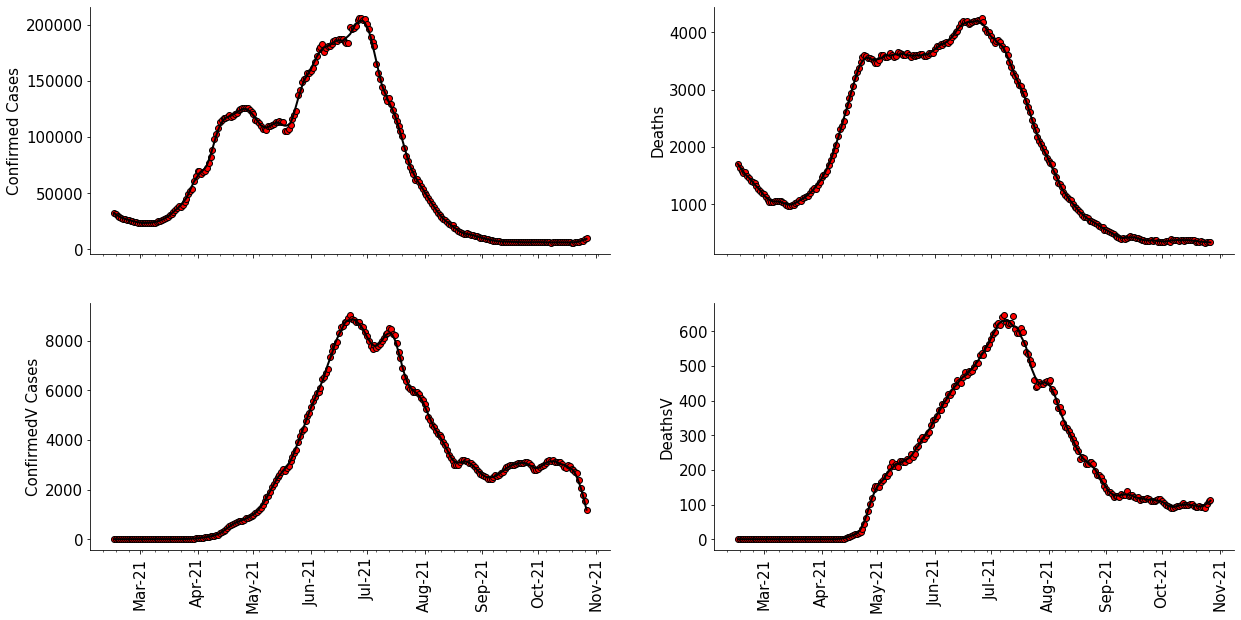

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(20.5, 10), sharex=True)

ax[0,0].scatter(obs_df.index.values, obs_df["I_NV+PD"], edgecolor="k", facecolor="red")
ax[0,0].plot(obs_df.index.values, obs_df["smoothed_I_NV+PD"], color="k", lw=2)

ax[0,1].scatter(obs_df.index.values, obs_df["M_NV+PD"], edgecolor="k", facecolor="red")
ax[0,1].plot(obs_df.index.values, obs_df["smoothed_M_NV+PD"], color="k", lw=2)

ax[1,0].scatter(obs_df.index.values, obs_df["InfectadosEsquemaCompleto"], edgecolor="k", facecolor="red")
ax[1,0].plot(obs_df.index.values, obs_df["smoothed_InfectadosEsquemaCompleto"], color="k", lw=2)

ax[1,1].scatter(obs_df.index.values, obs_df["MuertesEsquemaCompleto"], edgecolor="k", facecolor="red")
ax[1,1].plot(obs_df.index.values, obs_df["smoothed_MuertesEsquemaCompleto"], color="k", lw=2)

for axi in ax.flatten():
    axi.xaxis.set_major_locator(mdates.MonthLocator())
    axi.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
    axi.xaxis.set_minor_locator(mdates.WeekdayLocator())
    axi.tick_params( which='both', axis='both', labelsize=15)
    axi.tick_params( which='both', axis='x', rotation=90, labelsize=15)

    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)
ax[0,0].set_ylabel("Confirmed Cases", fontsize=15)
ax[0,1].set_ylabel("Deaths", fontsize=15)
ax[1,0].set_ylabel("ConfirmedV Cases", fontsize=15)
ax[1,1].set_ylabel("DeathsV", fontsize=15)
plt.show()

In [5]:
from scipy.stats import truncnorm
import numpy as np

dict_params_gain = {'beta':0.02, 'alpha': 0.05}

def checkbound_eafk(dx, dict_params_gain):
    for idx_p, p in enumerate(dict_params_gain.keys()):
        upp  = dict_params_gain[p]
        dx[idx_p,:] = np.clip(dx[idx_p,:], -upp, upp)
    return dx
        
        

def eakf_step(x_prior, params_prior, obs_ens_time, obs_time, oev_time, dict_params_range, num_var=4):

    prior_mean_ct = obs_ens_time.mean()
    prior_var_ct  = obs_ens_time.var()

    if prior_mean_ct == 0:
        post_var_ct  = 1e-3
        prior_var_ct = 1e-3


    post_var_ct  = prior_var_ct * oev_time / (prior_var_ct + oev_time)
    post_mean_ct = post_var_ct * (prior_mean_ct/prior_var_ct + obs_time / oev_time)
    alpha        = oev_time / (oev_time+prior_var_ct); alpha = alpha**0.5
    dy           = post_mean_ct + alpha*( obs_ens_time - prior_mean_ct ) - obs_ens_time

    # adjust parameters
    rr = []
    for idx_p, p in enumerate(dict_params_range.keys()):
        A = np.cov(params_prior[idx_p,:], obs_ens_time)
        rr.append( A[1,0] / prior_var_ct )

    rr = np.array(rr)
    dx = np.dot( np.expand_dims(rr,-1), np.expand_dims(dy, 0) )
#     dx = checkbound_eafk(dx, dict_params_gain)
    
    param_post = params_prior + dx

    # adjust variables
    rr = []
    for idx_var in range(num_var):
        A = np.cov(x_prior[idx_var,:], obs_ens_time)
        rr.append( A[1,0] / prior_var_ct )

    rr       = np.array(rr)
    dx       = np.dot( np.expand_dims(rr,-1), np.expand_dims(dy, 0) )
    x_post   = x_prior + dx

    obs_post    = obs_ens_time + dy

    return x_post, param_post, obs_post

def checkbound_params(dict_params_range, params_ens, num_ensembles=300):
    params_update = []
    for idx_p, p in enumerate(dict_params_range.keys()):
        loww = dict_params_range[p][0]
        upp  = dict_params_range[p][1]

        p_ens = params_ens[idx_p, :].copy()

        idx_wrong      = np.where(np.logical_or(p_ens <loww, p_ens > upp))[0]

        idx_wrong_loww = np.where(p_ens < loww)[0]
        idx_wrong_upp  = np.where(p_ens > upp)[0]

        idx_good  = np.where(np.logical_or(p_ens >=loww, p_ens <= upp))[0]

        p_ens[idx_wrong] = np.median(p_ens[idx_good])

        np.put(p_ens, idx_wrong_loww, loww * (1+0.2*np.random.rand( idx_wrong_loww.shape[0])) )
        np.put(p_ens, idx_wrong_upp, upp * (1-0.2*np.random.rand( idx_wrong_upp.shape[0])) )

        params_update.append(p_ens)

    return np.array(params_update)

def checkbound_state_vars(x_state_ens, pop, num_params=8, num_ensembles=300):
    loww = 0
    upp  = pop
    x_state_ens[0] = pop - sum(x_state_ens[1:6,:]) - sum(x_state_ens[8:14,:]) - x_state_ens[7,:] - x_state_ens[15,:]
    x_state_ens = np.clip(x_state_ens, 0, upp)
    return x_state_ens

def inflate_ensembles(ens, inflation_value=1.2, num_ensembles=300):
    return np.mean(ens,1, keepdims=True)*np.ones((1,num_ensembles)) + inflation_value*(ens-np.mean(ens,1, keepdims=True)*np.ones((1,num_ensembles)))

def sample_params_uniform(dict_params_range, num_ensembles=100):
    param_ens_prior = []
    for p in dict_params_range.keys():
        param_ens_prior.append( np.random.uniform( dict_params_range[p][0], dict_params_range[p][1]  , size=num_ensembles) )
    return np.array( param_ens_prior )

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm( (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd )

def sample_params_normal(dict_params_range, params_mean, params_var, num_ensembles=300):
    param_ens_prior = []
    for idx_p, p in enumerate(dict_params_range.keys()):
        norm_gen = get_truncated_normal(mean=params_mean[idx_p], sd=params_var[idx_p]**(1/2), low=dict_params_range[p][0], upp=dict_params_range[p][1])

        param_ens_prior.append( norm_gen.rvs(num_ensembles) )

    return np.array( param_ens_prior )

In [1]:
import time

print(f"Running MIF  \n")

cont = 0
cont1 = 0
for n in tqdm(range(num_iters_mif)): 
    if (n%num_save_iters)==0:
        obs_post_save = np.zeros((num_observations, num_ensembles, num_steps, num_save_iters))
        x_post_save = np.zeros((num_state_vars, num_ensembles, num_steps, num_save_iters))
        cont1 = 0
        
    if n==0:
        p_prior       = np.zeros((3,200))
        p_prior[:,:] = np.mean(param_prior.copy()[:,:,-1,:],-1)#sample_params_uniform(param_prior_dict, num_ensembles=num_ensembles)
        p_prior[2,:]  = sample_params_uniform(param_prior_dictV, num_ensembles=num_ensembles)
        theta[:, n] = np.mean(p_prior, -1)
        x           = np.mean(x_posterior[:,:,-1,:],-1)#init_modelV(N,num_ensembles=num_ensembles,num_variables= num_state_vars)

    else:
        p_prior     = np.zeros((3,200))
        params_mean = theta[:,n]
        params_var  = SIG * (alpha_mif**(n))**2
        p_prior[:,:] = np.mean(param_prior.copy()[:,:,-1,:],-1)#sample_params_normal(param_prior_dict, params_mean, params_var, num_ensembles=num_ensembles)
        p_prior[2,:]  = sample_params_normal(param_prior_dictV, [1231], [1000], num_ensembles=num_ensembles)
#         p_prior[2,:]  = (p_prior[2, :]- min(p_prior[2, :]))/(max(p_prior[2, :])-min(p_prior[2, :]))*82373.0
        x           = np.mean(x_posterior[:,:,-1,:],-1)#init_modelV(N,num_ensembles=num_ensembles,num_variables= num_state_vars)

    param_post_time = np.zeros((num_params, num_ensembles, num_steps))
    x_post_time     = np.zeros((num_state_vars, num_ensembles, num_steps))
    obs_post_time   = np.zeros((num_observations, num_ensembles, num_steps))
    idx_date_update = 0

    confirmed_t      = np.zeros((num_ensembles, 1))
    deaths_t         = np.zeros((num_ensembles, 1))
    confirmedV_t     = np.zeros((num_ensembles, 1))
    deathsV_t        = np.zeros((num_ensembles, 1))

    st = time.time()
    for idx_t, date in enumerate(dates):

        beta  = p_prior[0, :]
        alpha = p_prior[1, :]
#         p_prior[2,:]  = (p_prior[2, :]- min(p_prior[2, :]))/(max(p_prior[2, :])-min(p_prior[2, :]))*82373.0
        Vr    = p_prior[2,:]
        x_ens = modelV(x, beta, ifr_m, iVfr, Vr, alpha, N)
        x     = x_ens

        confirmed_t      +=  np.expand_dims(x_ens[6,:], -1)
        deaths_t         +=  np.expand_dims(x_ens[7,:], -1)
        confirmedV_t     +=  np.expand_dims(x_ens[14,:], -1)
        deathsV_t        +=  np.expand_dims(x_ens[15,:], -1)
        
#         pop = pop - np.median(x_ens[7,:]) - np.median(x_ens[15,:])

        # correct using daily observations
        if pd.to_datetime(date) == pd.to_datetime(dates_assimilation[idx_date_update]):

            x = inflate_ensembles(x, inflation_value=lambda_inf, num_ensembles=num_ensembles)
            x = checkbound_state_vars(x_state_ens=x, pop=N, num_params=num_params, num_ensembles=num_ensembles)

            p_prior = inflate_ensembles(p_prior, inflation_value=lambda_inf, num_ensembles=num_ensembles)
            p_prior = checkbound_params(param_prior_dict, p_prior, num_ensembles=num_ensembles)

            param_post = p_prior.copy()
            # Update parameters using confirmed cases
            x_prior = x.copy()

            oev_deaths_time = oev_df.loc[date]["OEV_deaths"]
            deaths_time = obs_df.loc[date]["smoothed_M_NV+PD"]

            # Update parameters using confirmed deaths
            x_post, param_post, deaths_obs_post = eakf_step(x, param_post, np.squeeze(deaths_t), deaths_time, oev_deaths_time, param_prior_dict, num_var= num_state_vars)

            x_post     = checkbound_state_vars(x_state_ens=x_post, pop=N, num_params= num_state_vars, num_ensembles= num_ensembles)
            param_post = checkbound_params(param_prior_dict, params_ens=param_post, num_ensembles= num_ensembles)

            oev_deathsV_time = oev_df.loc[date]["OEV_deathsV"]
            deathsV_time = obs_df.loc[date]["smoothed_MuertesEsquemaCompleto"]

            # Update parameters using confirmed deaths 
            x_post, param_post, deathsV_obs_post = eakf_step(x_post, param_post, np.squeeze(deathsV_t), deathsV_time, oev_deathsV_time, param_prior_dict, num_var= num_state_vars)

            x_post     = checkbound_state_vars(x_state_ens=x_post, pop=N, num_params= num_state_vars, num_ensembles= num_ensembles)
            param_post = checkbound_params(param_prior_dict, params_ens=param_post, num_ensembles= num_ensembles)


            oev_confirmed_time = oev_df.loc[date]["OEV_confirmed"]
            confirmed_time = obs_df.loc[date]["smoothed_I_NV+PD"]


            x_post, param_post, confirmed_obs_post = eakf_step(x_post, param_post, np.squeeze(confirmed_t), confirmed_time, oev_confirmed_time, param_prior_dict, num_var=num_state_vars)

            x_post     = checkbound_state_vars(x_state_ens=x_post, pop=N, num_params=num_state_vars, num_ensembles=num_ensembles)
            param_post = checkbound_params(param_prior_dict, params_ens=param_post, num_ensembles=num_ensembles)


            oev_confirmedV_time = oev_df.loc[date]["OEV_confirmedV"]
            confirmedV_time = obs_df.loc[date]["smoothed_InfectadosEsquemaCompleto"]


            x_post, param_post, confirmedV_obs_post = eakf_step(x_post, param_post, np.squeeze(confirmedV_t), confirmedV_time, oev_confirmedV_time, param_prior_dict, num_var=num_state_vars)

            x_post     = checkbound_state_vars(x_state_ens=x_post, pop=N, num_params=num_state_vars, num_ensembles=num_ensembles)
            param_post = checkbound_params(param_prior_dict, params_ens=param_post, num_ensembles=num_ensembles)

            x = x_post.copy()

            # Use posterior and next prior
            p_prior = param_post.copy()

            obs_post_time[0,:,idx_date_update]    = confirmed_obs_post
            obs_post_time[1,:,idx_date_update]    = deaths_obs_post
            obs_post_time[2,:,idx_date_update]    = confirmedV_obs_post
            obs_post_time[3,:,idx_date_update]    = deathsV_obs_post
            param_post_time[:,:,idx_date_update]  = param_post
            x_post_time[:,:,idx_date_update]      = x_post

            idx_date_update += 1

            confirmed_t    = np.zeros((num_ensembles, 1))
            deaths_t       = np.zeros((num_ensembles, 1))
            confirmedV_t    = np.zeros((num_ensembles, 1))
            deathsV_t       = np.zeros((num_ensembles, 1))


    et = time.time()
    
    x_post_save[:,:,:,cont1]   = x_post_time                                                     
    obs_post_save[:,:,:,cont1] = obs_post_time
    para_post_all[:,:,:,n] = param_post_time
    cont1 += 1
    if (n+1)%num_save_iters == 0 and n != 0:
        obs_post_all[:,:,:,cont] = obs_post_save.mean(-1)
        print(obs_post_save.mean())
        x_post_all[:,:,:,cont]       = x_post_save.mean(-1)
        cont += 1
        np.savez_compressed('../results/samples_aggV_Final2_{}.npz'.format(n+1),
                                param_posterior     = para_post_all,
                                x_posterior         = x_post_all,
                                obs_posterior       = obs_post_all,)

    theta[:,n+1] = param_post_time.mean(-1).mean(-1)

SyntaxError: invalid syntax (<ipython-input-1-c1f7dbc87998>, line 20)

In [7]:
def create_df_response(samples, time, date_init ='2020-03-06',  quantiles = [50, 80, 95], forecast_horizon=27, dates=None, use_future=False):
    """[summary]

    Args:
        samples ([type]): [description]
        time ([type]): [description]
        date_init (str, optional): [description]. Defaults to '2020-03-06'.
        forecast_horizon (int, optional): [description]. Defaults to 27.
        use_future (bool, optional): [description]. Defaults to False.

    Returns:
        [type]: [description]
    """
    if dates is not None:
        dates_fitted = dates
    else:
        dates_fitted   = pd.date_range(start=pd.to_datetime(date_init), periods=time)
        dates_forecast = pd.date_range(start=dates_fitted[-1]+datetime.timedelta(1), periods=forecast_horizon)

    dates = list(dates_fitted)
    types = ['estimate']*len(dates_fitted)
    if use_future:
        dates += list(dates_forecast)
        types  += ['forecast']*len(dates_forecast)

    results_df = pd.DataFrame(samples.T)
    df_response = pd.DataFrame(index=dates)
    # Calculate key statistics
    df_response['mean']        = results_df.mean(axis=1).values
    df_response['median']      = results_df.median(axis=1).values
    df_response['std']         = results_df.std(axis=1).values

    for quant in quantiles:
        low_q  = ((100-quant)/2)/100
        high_q = 1-low_q

        df_response[f'low_{quant}']  = results_df.quantile(q=low_q, axis=1).values
        df_response[f'high_{quant}'] = results_df.quantile(q=high_q, axis=1).values

    df_response['type']        =  types
    df_response.index.name = 'date'
    return df_response

In [8]:
param_time = np.mean(para_post_all[:,:,:,:], -1)

df_beta  = create_df_response(param_time[0,:,:], time=num_steps, dates =dates_assimilation)
df_alpha = create_df_response(param_time[1,:,:], time=num_steps, dates =dates_assimilation)


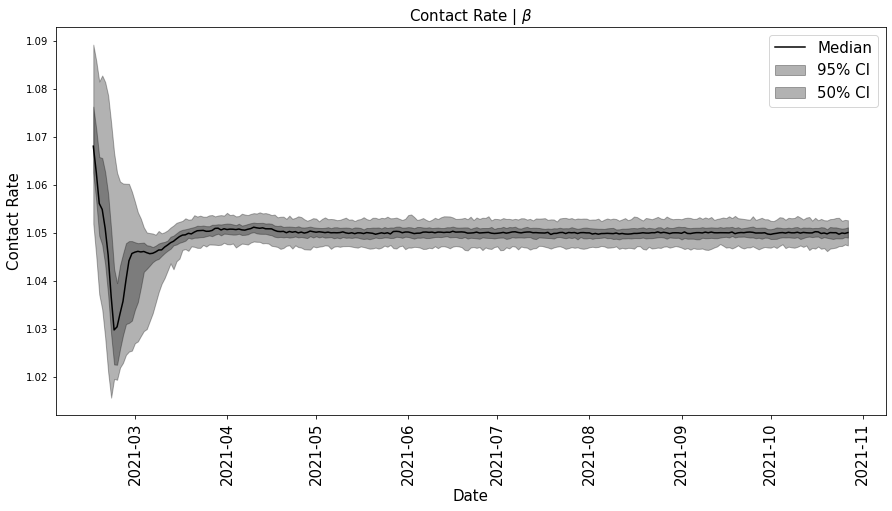

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12.5, 7.2))
ax.plot(df_beta.index.values, df_beta["median"], color='k', label='Median')
ax.fill_between(df_beta.index.values, df_beta["high_95"], df_beta["low_95"], color='k', alpha=0.3, label='95% CI')
ax.fill_between(df_beta.index.values, df_beta["high_50"], df_beta["low_50"], color='k', alpha=0.3, label='50% CI')

ax.tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax.set_xlabel("Date", fontsize=15)
ax.set_ylabel("Contact Rate", fontsize=15)
ax.set_title(r"Contact Rate | $\beta$ ", fontsize=15)
ax.legend(fontsize=15, loc='best')
plt.tight_layout()
# plt.ylim(1)
plt.show()

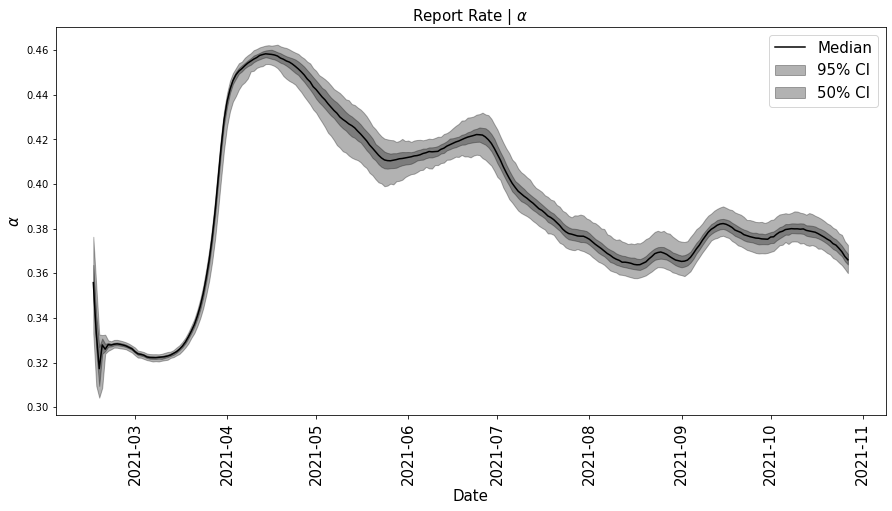

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12.5, 7.2))

ax.plot(df_alpha.index.values, df_alpha["median"], color='k', label='Median')
ax.fill_between(df_alpha.index.values, df_alpha["high_95"], df_alpha["low_95"], color='k', alpha=0.3, label='95% CI')
ax.fill_between(df_alpha.index.values, df_alpha["high_50"], df_alpha["low_50"], color='k', alpha=0.3, label='50% CI')

ax.tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax.set_xlabel("Date", fontsize=15)
ax.set_ylabel(r"$\alpha$", fontsize=15)
ax.set_title(r"Report Rate | $\alpha$ ", fontsize=15)
ax.legend(fontsize=15, loc='best')
plt.tight_layout()
# plt.ylim(0.2)
plt.show()

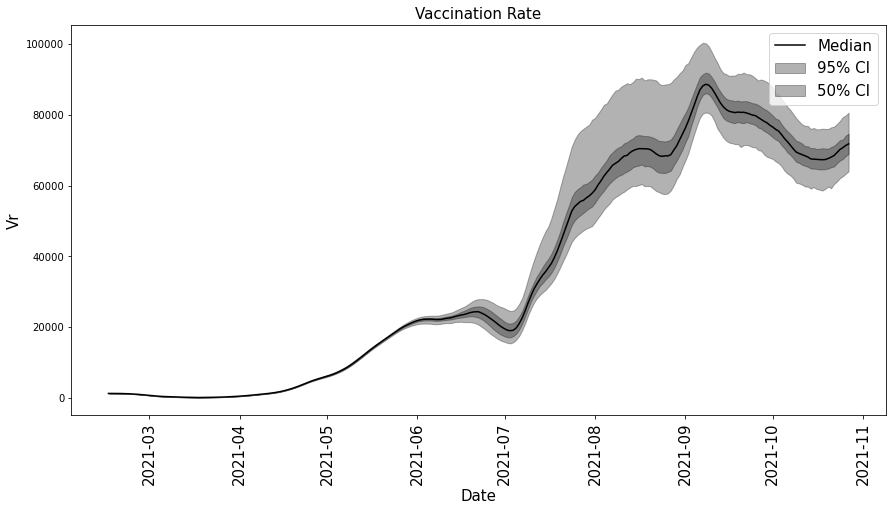

In [11]:
df_Vr     = create_df_response(param_time[2,:,:], time=num_steps, dates =dates_assimilation)
fig, ax = plt.subplots(1, 1, figsize=(12.5, 7.2))

ax.plot(df_Vr.index.values, df_Vr["median"], color='k', label='Median')
ax.fill_between(df_Vr.index.values, df_Vr["high_95"], df_Vr["low_95"], color='k', alpha=0.3, label='95% CI')
ax.fill_between(df_Vr.index.values, df_Vr["high_50"], df_Vr["low_50"], color='k', alpha=0.3, label='50% CI')

ax.tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax.set_xlabel("Date", fontsize=15)
ax.set_ylabel(r"Vr", fontsize=15)
ax.set_title(r"Vaccination Rate", fontsize=15)
ax.legend(fontsize=15, loc='best')
plt.tight_layout()
# plt.ylim(0.2)
plt.show()

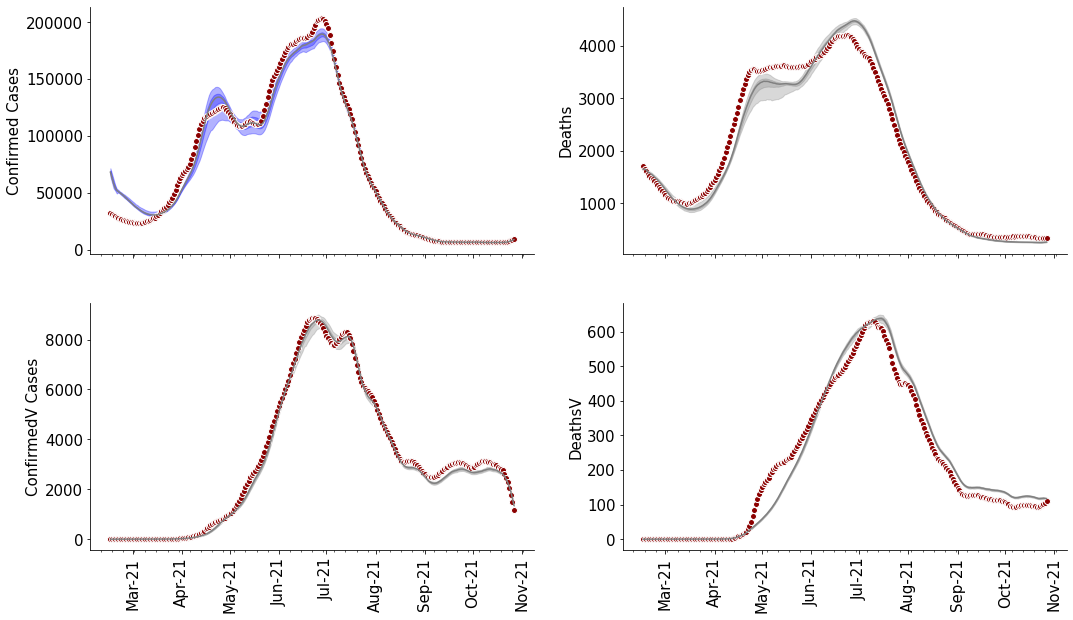

In [12]:
confirmed_post_all    = obs_post_all[0,:,:,:]
deaths_post_all       = obs_post_all[1,:,:,:]
confirmedV_post_all    = obs_post_all[2,:,:,:]
deathsV_post_all       = obs_post_all[3,:,:,:]


take_post        = 3
df_confirmed     = create_df_response(np.take(np.squeeze(confirmed_post_all), axis=2, indices=take_post), time=num_steps, dates =dates_assimilation)
df_deaths        = create_df_response(np.take(np.squeeze(deaths_post_all), axis=2, indices=take_post), time=num_steps, dates =dates_assimilation)
df_confirmedV     = create_df_response(np.take(np.squeeze(confirmedV_post_all), axis=2, indices=take_post), time=num_steps, dates =dates_assimilation)
df_deathsV        = create_df_response(np.take(np.squeeze(deathsV_post_all), axis=2, indices=take_post), time=num_steps, dates =dates_assimilation)


fig, ax = plt.subplots(2, 2, figsize=(17.5, 10), sharex=True)

ax[0,0].plot(df_confirmed.index.values, df_confirmed["median"], color='gray', label='Median')
ax[0,0].fill_between(df_confirmed.index.values, df_confirmed["high_95"], df_confirmed["low_95"], color='blue', alpha=0.3, label='95% CI')
ax[0,0].fill_between(df_confirmed.index.values, df_confirmed["high_50"], df_confirmed["low_50"], color='blue', alpha=0.3, label='50% CI')
ax[0,0].scatter(obs_df.index.values, obs_df["smoothed_I_NV+PD"], edgecolors="w", facecolor="darkred")

ax[0,1].plot(df_deaths.index.values, df_deaths["median"], color='gray', label='Median')
ax[0,1].fill_between(df_deaths.index.values, df_deaths["high_95"], df_deaths["low_95"], color='gray', alpha=0.3, label='95% CI')
ax[0,1].fill_between(df_deaths.index.values, df_deaths["high_50"], df_deaths["low_50"], color='gray', alpha=0.3, label='50% CI')
ax[0,1].scatter(obs_df.index.values, obs_df["smoothed_M_NV+PD"], edgecolors="w", facecolor="darkred")

ax[1,0].plot(df_confirmedV.index.values, df_confirmedV["median"], color='gray', label='Median')
ax[1,0].fill_between(df_confirmedV.index.values, df_confirmedV["high_95"], df_confirmedV["low_95"], color='gray', alpha=0.3, label='95% CI')
ax[1,0].fill_between(df_confirmedV.index.values, df_confirmedV["high_50"], df_confirmedV["low_50"], color='gray', alpha=0.3, label='50% CI')
ax[1,0].scatter(obs_df.index.values, obs_df["smoothed_InfectadosEsquemaCompleto"], edgecolors="w", facecolor="darkred")

ax[1,1].plot(df_deathsV.index.values, df_deathsV["median"], color='gray', label='Median')
ax[1,1].fill_between(df_deathsV.index.values, df_deathsV["high_95"], df_deathsV["low_95"], color='gray', alpha=0.3, label='95% CI')
ax[1,1].fill_between(df_deathsV.index.values, df_deathsV["high_50"], df_deathsV["low_50"], color='gray', alpha=0.3, label='50% CI')
ax[1,1].scatter(obs_df.index.values, obs_df["smoothed_MuertesEsquemaCompleto"], edgecolors="w", facecolor="darkred")

for axi in ax.flatten():
    axi.xaxis.set_major_locator(mdates.MonthLocator())
    axi.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
    axi.xaxis.set_minor_locator(mdates.WeekdayLocator())
    axi.tick_params( which='both', axis='both', labelsize=15)
    axi.tick_params( which='both', axis='x', rotation=90, labelsize=15)

    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)

ax[0,0].set_ylabel("Confirmed Cases", fontsize=15)
ax[0,1].set_ylabel("Deaths", fontsize=15)
ax[1,0].set_ylabel("ConfirmedV Cases", fontsize=15)
ax[1,1].set_ylabel("DeathsV", fontsize=15)

plt.show()

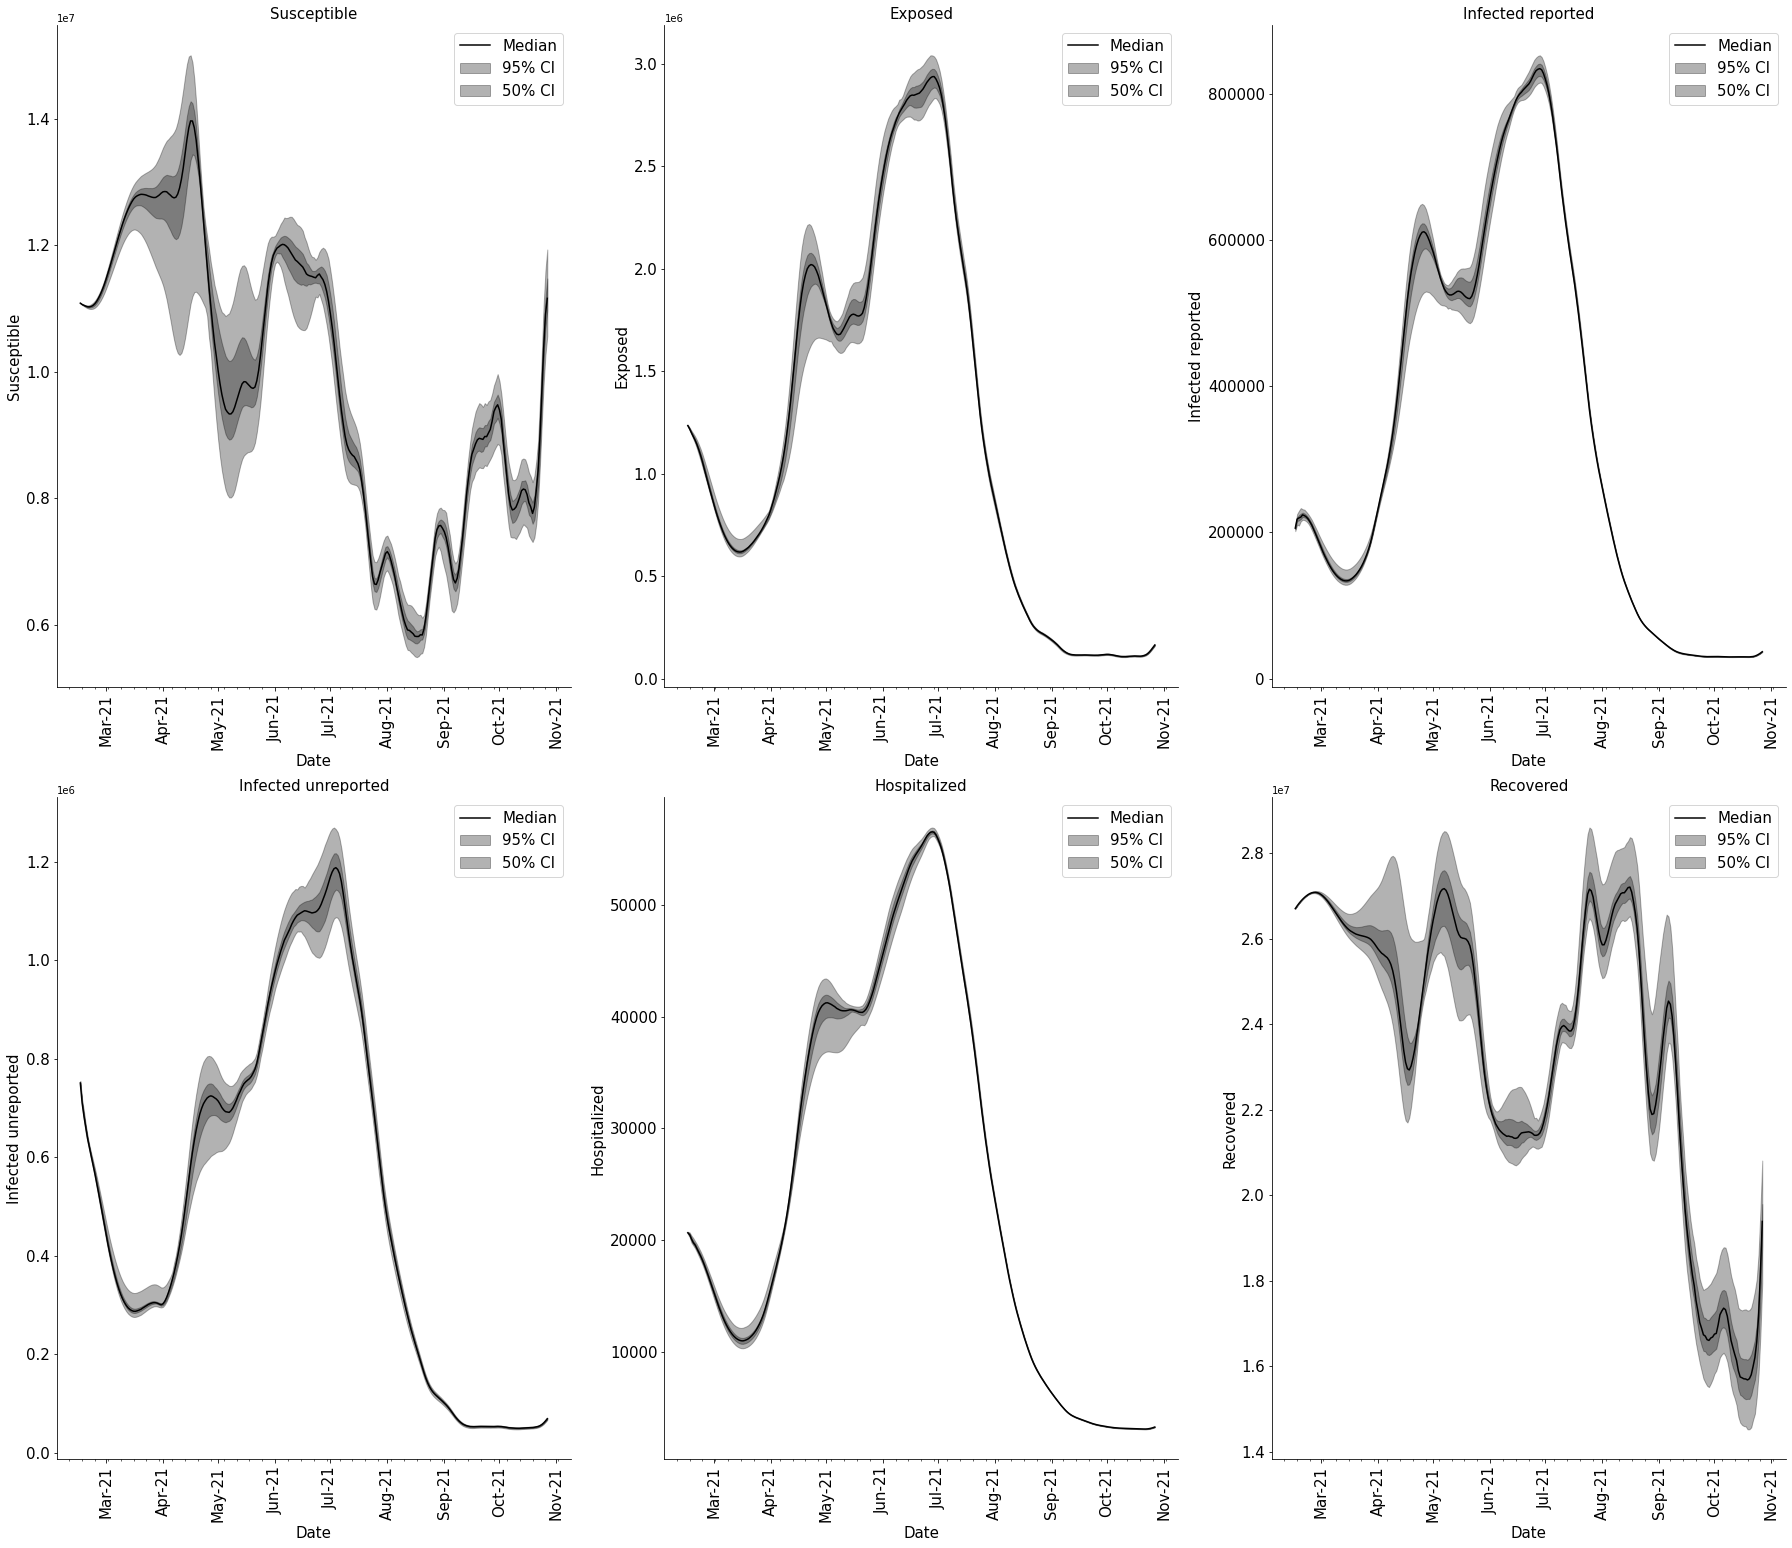

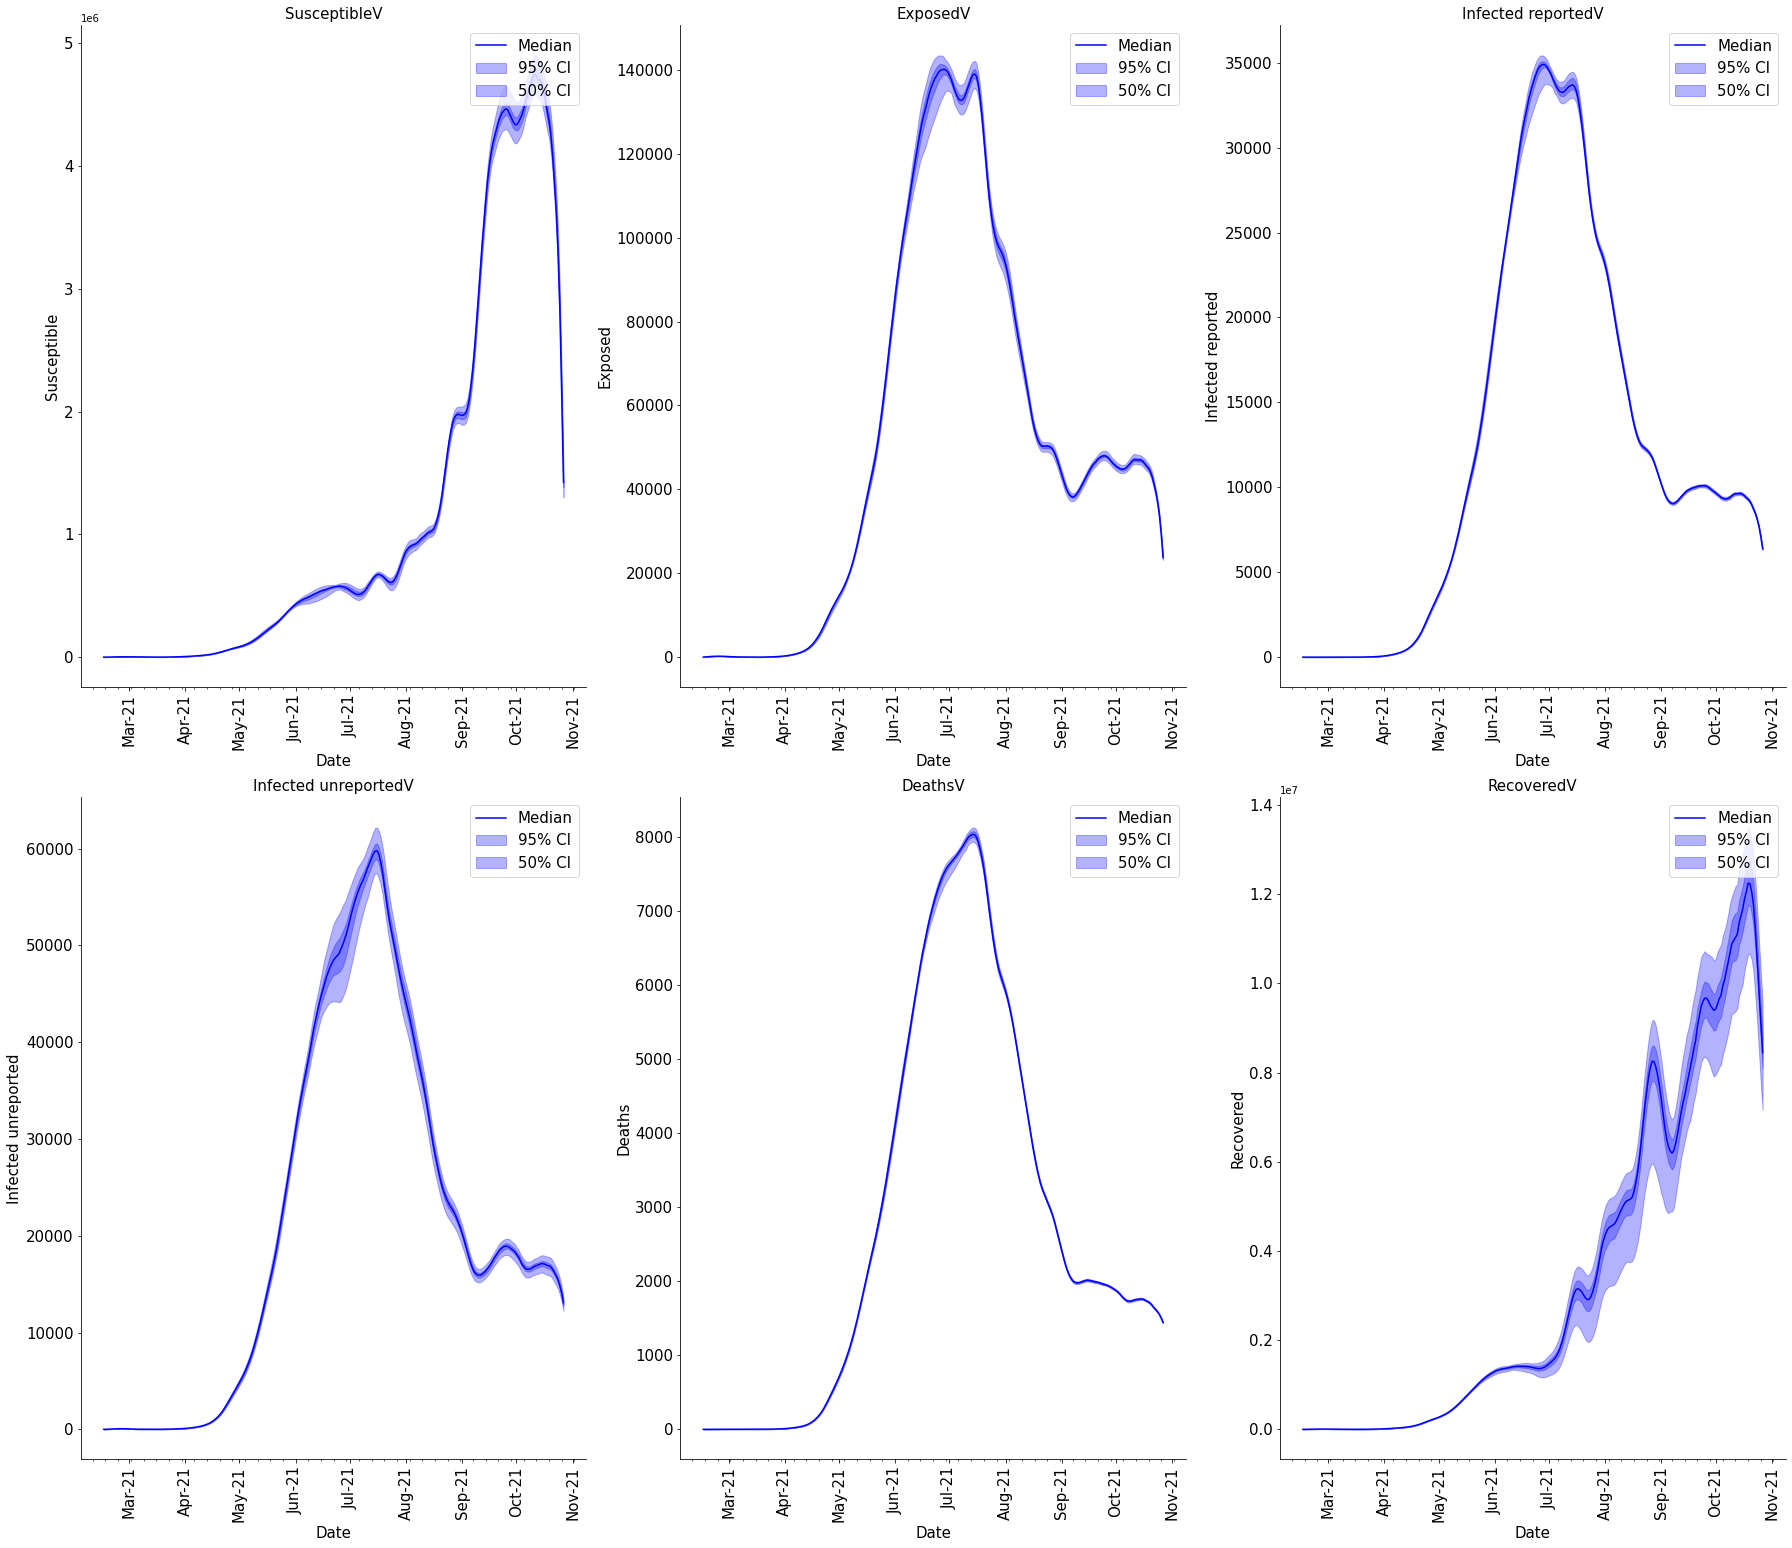

In [13]:
S_time = np.mean(x_post_all[0,:,:,:], -1)
E_time = np.mean(x_post_all[1,:,:,:], -1)
Ir_time = np.mean(x_post_all[2,:,:,:], -1)
Iu_time = np.mean(x_post_all[3,:,:,:], -1)
Id_time = np.mean(x_post_all[4,:,:,:], -1)
R_time = np.mean(x_post_all[5,:,:,:], -1)
# H_time = np.mean(x_post_all[6,:,:,:], -1)
C_time = np.mean(x_post_all[6,:,:,:], -1)
D_time = np.mean(x_post_all[7,:,:,:], -1)

df_S  = create_df_response(S_time, time=num_steps, dates =dates_assimilation)
df_E  = create_df_response(E_time, time=num_steps, dates =dates_assimilation)
df_Ir  = create_df_response(Ir_time, time=num_steps, dates =dates_assimilation)
df_Iu  = create_df_response(Iu_time, time=num_steps, dates =dates_assimilation)
df_Id  = create_df_response(Id_time, time=num_steps, dates =dates_assimilation)
df_R  = create_df_response(R_time, time=num_steps, dates =dates_assimilation)
# df_H  = create_df_response(C_time, time=num_steps, dates =dates_assimilation)
df_C  = create_df_response(C_time, time=num_steps, dates =dates_assimilation)
df_D  = create_df_response(D_time, time=num_steps, dates =dates_assimilation)

#---------------------------------------------------------------

fig, ax = plt.subplots(2, 3, figsize=(25, 21.6))

ax[0,0].plot(df_S.index.values, df_S["median"], color='k', label='Median')
ax[0,0].fill_between(df_S.index.values, df_S["high_95"], df_S["low_95"], color='k', alpha=0.3, label='95% CI')
ax[0,0].fill_between(df_S.index.values, df_S["high_50"], df_S["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[0,0].xaxis.set_major_locator(mdates.MonthLocator())
ax[0,0].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[0,0].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[0,0].tick_params( which='both', axis='both', labelsize=15)
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['top'].set_visible(False)

ax[0,0].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[0,0].set_xlabel("Date", fontsize=15)
ax[0,0].set_ylabel("Susceptible", fontsize=15)
ax[0,0].set_title("Susceptible", fontsize=15)
ax[0,0].legend(fontsize=15, loc='upper right')
plt.tight_layout()

#---------------------------------------------------------------

ax[0,1].plot(df_E.index.values, df_E["median"], color='k', label='Median')
ax[0,1].fill_between(df_E.index.values, df_E["high_95"], df_E["low_95"], color='k', alpha=0.3, label='95% CI')
ax[0,1].fill_between(df_E.index.values, df_E["high_50"], df_E["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[0,1].xaxis.set_major_locator(mdates.MonthLocator())
ax[0,1].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[0,1].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[0,1].tick_params( which='both', axis='both', labelsize=15)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['top'].set_visible(False)

ax[0,1].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[0,1].set_xlabel("Date", fontsize=15)
ax[0,1].set_ylabel("Exposed", fontsize=15)
ax[0,1].set_title("Exposed", fontsize=15)
ax[0,1].legend(fontsize=15, loc='upper right')
plt.tight_layout()

#---------------------------------------------------------------

ax[0,2].plot(df_Ir.index.values, df_Ir["median"], color='k', label='Median')
ax[0,2].fill_between(df_Ir.index.values, df_Ir["high_95"], df_Ir["low_95"], color='k', alpha=0.3, label='95% CI')
ax[0,2].fill_between(df_Ir.index.values, df_Ir["high_50"], df_Ir["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[0,2].xaxis.set_major_locator(mdates.MonthLocator())
ax[0,2].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[0,2].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[0,2].tick_params( which='both', axis='both', labelsize=15)
ax[0,2].spines['right'].set_visible(False)
ax[0,2].spines['top'].set_visible(False)

ax[0,2].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[0,2].set_xlabel("Date", fontsize=15)
ax[0,2].set_ylabel("Infected reported", fontsize=15)
ax[0,2].set_title("Infected reported", fontsize=15)
ax[0,2].legend(fontsize=15, loc='upper right')
plt.tight_layout()

#---------------------------------------------------------------

ax[1,0].plot(df_Iu.index.values, df_Iu["median"], color='k', label='Median')
ax[1,0].fill_between(df_Iu.index.values, df_Iu["high_95"], df_Iu["low_95"], color='k', alpha=0.3, label='95% CI')
ax[1,0].fill_between(df_Iu.index.values, df_Iu["high_50"], df_Iu["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[1,0].xaxis.set_major_locator(mdates.MonthLocator())
ax[1,0].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[1,0].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[1,0].tick_params( which='both', axis='both', labelsize=15)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['top'].set_visible(False)

ax[1,0].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[1,0].set_xlabel("Date", fontsize=15)
ax[1,0].set_ylabel("Infected unreported", fontsize=15)
ax[1,0].set_title("Infected unreported", fontsize=15)
ax[1,0].legend(fontsize=15, loc='upper right')
plt.tight_layout()

#---------------------------------------------------------------

ax[1,1].plot(df_Id.index.values, df_Id["median"], color='k', label='Median')
ax[1,1].fill_between(df_Id.index.values, df_Id["high_95"], df_Id["low_95"], color='k', alpha=0.3, label='95% CI')
ax[1,1].fill_between(df_Id.index.values, df_Id["high_50"], df_Id["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[1,1].xaxis.set_major_locator(mdates.MonthLocator())
ax[1,1].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[1,1].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[1,1].tick_params( which='both', axis='both', labelsize=15)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['top'].set_visible(False)

ax[1,1].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[1,1].set_xlabel("Date", fontsize=15)
ax[1,1].set_ylabel("Hospitalized", fontsize=15)
ax[1,1].set_title("Hospitalized", fontsize=15)
ax[1,1].legend(fontsize=15, loc='upper right')
plt.tight_layout()

#---------------------------------------------------------------

ax[1,2].plot(df_R.index.values, df_R["median"], color='k', label='Median')
ax[1,2].fill_between(df_R.index.values, df_R["high_95"], df_R["low_95"], color='k', alpha=0.3, label='95% CI')
ax[1,2].fill_between(df_R.index.values, df_R["high_50"], df_R["low_50"], color='k', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[1,2].xaxis.set_major_locator(mdates.MonthLocator())
ax[1,2].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[1,2].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[1,2].tick_params( which='both', axis='both', labelsize=15)
ax[1,2].spines['right'].set_visible(False)
ax[1,2].spines['top'].set_visible(False)

ax[1,2].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[1,2].set_xlabel("Date", fontsize=15)
ax[1,2].set_ylabel("Recovered", fontsize=15)
ax[1,2].set_title("Recovered", fontsize=15)
ax[1,2].legend(fontsize=15, loc='upper right')
plt.tight_layout()


SV_time = np.mean(x_post_all[8,:,:,:], -1)
EV_time = np.mean(x_post_all[9,:,:,:], -1)
IVr_time = np.mean(x_post_all[10,:,:,:], -1)
IVu_time = np.mean(x_post_all[11,:,:,:], -1)
IVd_time = np.mean(x_post_all[12,:,:,:], -1)
RV_time = np.mean(x_post_all[13,:,:,:], -1)
# H_time = np.mean(x_post_all[15,:,:,:], -1)
CV_time = np.mean(x_post_all[14,:,:,:], -1)
DV_time = np.mean(x_post_all[15,:,:,:], -1)

df_SV  = create_df_response(SV_time, time=num_steps, dates =dates_assimilation)
df_EV  = create_df_response(EV_time, time=num_steps, dates =dates_assimilation)
df_Ir  = create_df_response(IVr_time, time=num_steps, dates =dates_assimilation)
df_Iu  = create_df_response(IVu_time, time=num_steps, dates =dates_assimilation)
df_Id  = create_df_response(IVd_time, time=num_steps, dates =dates_assimilation)
df_R  = create_df_response(RV_time, time=num_steps, dates =dates_assimilation)
# df_H  = create_df_response(C_time, time=num_steps, dates =dates_assimilation)
df_C  = create_df_response(CV_time, time=num_steps, dates =dates_assimilation)
df_D  = create_df_response(DV_time, time=num_steps, dates =dates_assimilation)

#---------------------------------------------------------------

fig, ax = plt.subplots(2, 3, figsize=(25, 21.6))

ax[0,0].plot(df_SV.index.values, df_SV["median"], color='b', label='Median')
ax[0,0].fill_between(df_SV.index.values, df_SV["high_95"], df_SV["low_95"], color='b', alpha=0.3, label='95% CI')
ax[0,0].fill_between(df_SV.index.values, df_SV["high_50"], df_SV["low_50"], color='b', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[0,0].xaxis.set_major_locator(mdates.MonthLocator())
ax[0,0].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[0,0].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[0,0].tick_params( which='both', axis='both', labelsize=15)
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['top'].set_visible(False)

ax[0,0].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[0,0].set_xlabel("Date", fontsize=15)
ax[0,0].set_ylabel("Susceptible", fontsize=15)
ax[0,0].set_title("SusceptibleV", fontsize=15)
ax[0,0].legend(fontsize=15, loc='upper right')
plt.tight_layout()

#---------------------------------------------------------------

ax[0,1].plot(df_EV.index.values, df_EV["median"], color='b', label='Median')
ax[0,1].fill_between(df_EV.index.values, df_EV["high_95"], df_EV["low_95"], color='b', alpha=0.3, label='95% CI')
ax[0,1].fill_between(df_EV.index.values, df_EV["high_50"], df_EV["low_50"], color='b', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[0,1].xaxis.set_major_locator(mdates.MonthLocator())
ax[0,1].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[0,1].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[0,1].tick_params( which='both', axis='both', labelsize=15)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['top'].set_visible(False)

ax[0,1].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[0,1].set_xlabel("Date", fontsize=15)
ax[0,1].set_ylabel("Exposed", fontsize=15)
ax[0,1].set_title("ExposedV", fontsize=15)
ax[0,1].legend(fontsize=15, loc='upper right')
plt.tight_layout()

#---------------------------------------------------------------

ax[0,2].plot(df_Ir.index.values, df_Ir["median"], color='b', label='Median')
ax[0,2].fill_between(df_Ir.index.values, df_Ir["high_95"], df_Ir["low_95"], color='b', alpha=0.3, label='95% CI')
ax[0,2].fill_between(df_Ir.index.values, df_Ir["high_50"], df_Ir["low_50"], color='b', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[0,2].xaxis.set_major_locator(mdates.MonthLocator())
ax[0,2].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[0,2].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[0,2].tick_params( which='both', axis='both', labelsize=15)
ax[0,2].spines['right'].set_visible(False)
ax[0,2].spines['top'].set_visible(False)

ax[0,2].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[0,2].set_xlabel("Date", fontsize=15)
ax[0,2].set_ylabel("Infected reported", fontsize=15)
ax[0,2].set_title("Infected reportedV", fontsize=15)
ax[0,2].legend(fontsize=15, loc='upper right')
plt.tight_layout()

#---------------------------------------------------------------

ax[1,0].plot(df_Iu.index.values, df_Iu["median"], color='b', label='Median')
ax[1,0].fill_between(df_Iu.index.values, df_Iu["high_95"], df_Iu["low_95"], color='b', alpha=0.3, label='95% CI')
ax[1,0].fill_between(df_Iu.index.values, df_Iu["high_50"], df_Iu["low_50"], color='b', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[1,0].xaxis.set_major_locator(mdates.MonthLocator())
ax[1,0].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[1,0].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[1,0].tick_params( which='both', axis='both', labelsize=15)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['top'].set_visible(False)

ax[1,0].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[1,0].set_xlabel("Date", fontsize=15)
ax[1,0].set_ylabel("Infected unreported", fontsize=15)
ax[1,0].set_title("Infected unreportedV", fontsize=15)
ax[1,0].legend(fontsize=15, loc='upper right')
plt.tight_layout()

#---------------------------------------------------------------

ax[1,1].plot(df_Id.index.values, df_Id["median"], color='b', label='Median')
ax[1,1].fill_between(df_Id.index.values, df_Id["high_95"], df_Id["low_95"], color='b', alpha=0.3, label='95% CI')
ax[1,1].fill_between(df_Id.index.values, df_Id["high_50"], df_Id["low_50"], color='b', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[1,1].xaxis.set_major_locator(mdates.MonthLocator())
ax[1,1].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[1,1].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[1,1].tick_params( which='both', axis='both', labelsize=15)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['top'].set_visible(False)

ax[1,1].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[1,1].set_xlabel("Date", fontsize=15)
ax[1,1].set_ylabel("Deaths", fontsize=15)
ax[1,1].set_title("DeathsV", fontsize=15)
ax[1,1].legend(fontsize=15, loc='upper right')
plt.tight_layout()

#---------------------------------------------------------------

ax[1,2].plot(df_R.index.values, df_R["median"], color='b', label='Median')
ax[1,2].fill_between(df_R.index.values, df_R["high_95"], df_R["low_95"], color='b', alpha=0.3, label='95% CI')
ax[1,2].fill_between(df_R.index.values, df_R["high_50"], df_R["low_50"], color='b', alpha=0.3, label='50% CI')

#sns.barplot(data=df_response, x='date', y='valuye')

ax[1,2].xaxis.set_major_locator(mdates.MonthLocator())
ax[1,2].xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
ax[1,2].xaxis.set_minor_locator(mdates.WeekdayLocator())
ax[1,2].tick_params( which='both', axis='both', labelsize=15)
ax[1,2].spines['right'].set_visible(False)
ax[1,2].spines['top'].set_visible(False)

ax[1,2].tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
ax[1,2].set_xlabel("Date", fontsize=15)
ax[1,2].set_ylabel("Recovered", fontsize=15)
ax[1,2].set_title("RecoveredV", fontsize=15)
ax[1,2].legend(fontsize=15, loc='upper right')
plt.tight_layout()

plt.show()

In [16]:
sum(np.median(np.mean(x_post_all,-1),1)[0:6,:])+sum(np.median(np.mean(x_post_all,-1),1)[8:14,:])

array([39998307.41930659, 39998360.28458039, 39998507.07268795,
       39998536.51840724, 39998542.33248015, 39998516.73708644,
       39998509.3568033 , 39998890.90546969, 39998997.37674761,
       39998969.44806582, 39999066.38505094, 39999363.4534821 ,
       39999546.08606804, 39999470.06456175, 39999245.8195509 ,
       39999079.96944872, 39998592.448427  , 39998813.6062159 ,
       39998487.75671506, 39998259.97830597, 39998172.95244254,
       39998802.76500007, 39998951.87817104, 39999087.70638745,
       39998690.79002904, 39998695.65233582, 39997872.44736584,
       39996637.63644936, 39996133.38331263, 39995634.5168303 ,
       39993127.00333081, 39990943.21429714, 39990742.85882808,
       39990316.53983629, 39989310.47949871, 39988199.87120561,
       39987486.88563455, 39987299.41577063, 39988042.04738836,
       39988132.93081798, 39988123.2944886 , 39987581.64022391,
       39987250.80430391, 39986981.62355989, 39986949.74775366,
       39987041.58977907, 39987106.14147

In [75]:
Rt_age = np.zeros((200,345))
beta_time = param_time[0,:,:]
alpha_time = param_time[1,:,:]
Rt_age =beta_time*(1-ihr)*(1/0.25)*(alpha_time+(0.5*(1-alpha_time)))


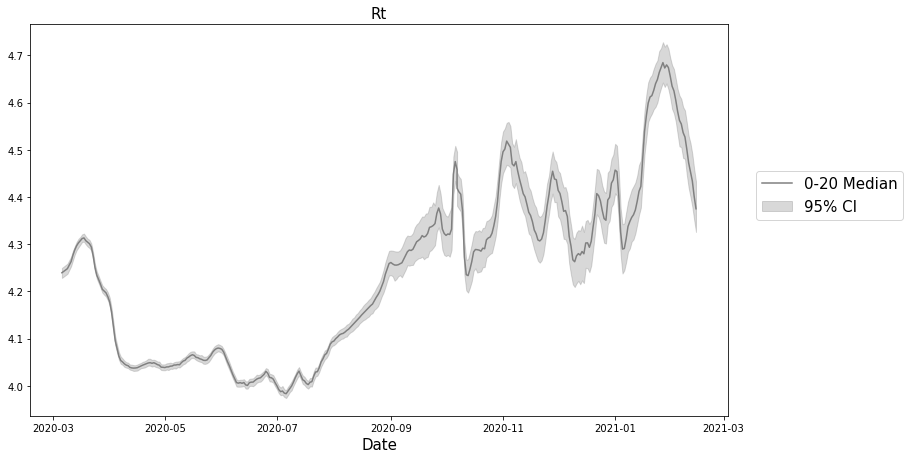

In [76]:
df_Rt0   = create_df_response(Rt_age, time=num_steps, dates =dates_assimilation)


fig, ax = plt.subplots(1, 1, figsize=(12.5, 7.2))

ax.plot(df_Rt0.index.values, df_Rt0["median"], color='gray', label='0-20 Median')
ax.fill_between(df_Rt0.index.values, df_Rt0["high_95"], df_Rt0["low_95"], color='gray', alpha=0.3, label='95% CI')

ax.set_xlabel("Date", fontsize=15)
# ax.set_ylabel(r"$\alpha$", fontsize=15)
ax.set_title("Rt", fontsize=15)
ax.legend(fontsize=15, loc=(1.04,0.5))